# HW notMNIST

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imread
from skimage.transform import resize
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from glob import glob
%config InlineBackend.figure_format = 'svg'

def load_notmnist(path='./notMNIST_small',letters='ABCDEFGHIJ',
                  img_shape=(28,28),test_size=0.25,one_hot=False):

    # download data if it's missing. If you have any problems, go to the urls and load it manually.
    if not os.path.exists(path):
        print("Downloading data...")
        assert os.system('curl http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz > notMNIST_small.tar.gz') == 0
        print("Extracting ...")
        assert os.system('tar -zxvf notMNIST_small.tar.gz > untar_notmnist.log') == 0

    data,labels = [],[]
    print("Parsing...")
    for img_path in glob(os.path.join(path,'*/*')):
        class_i = img_path.split(os.sep)[-2]
        if class_i not in letters:
            continue
        try:
            data.append(resize(imread(img_path), img_shape))
            labels.append(class_i,)
        except:
            print("found broken img: %s [it's ok if <10 images are broken]" % img_path)

    data = np.stack(data)[:,None].astype('float32')
    data = (data - np.mean(data)) / np.std(data)

    #convert classes to ints
    letter_to_i = {l:i for i,l in enumerate(letters)}
    labels = np.array(list(map(letter_to_i.get, labels)))

    if one_hot:
        labels = (np.arange(np.max(labels) + 1)[None,:] == labels[:, None]).astype('float32')

    #split into train/test
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, stratify=labels)

    print("Done")
    return X_train, y_train, X_test, y_test

## Task description

In this notebook you are suggested to train several models of machine learning on the notMNIST dataset. To get full points per each model it must beat the **baseline** on test dataset. Models to test:

* logistic regression, 86% (**1 point**)
* k-nearest neigbors, 88% (**1 point**)
* naive Bayes classifier, 80% (**1 point**)
* decision tree, 82% (**1 point**)
* random forest, 91% (**1 point**)
* MLP, 91% (**1.5 points**)
* CNN, 92% (**2 points**)
* overall comparison of models, including some graphs (e.g, bar plot) (**1 point**)

**Bonus**! Each percent above baseline will bring you **0.1 points**.

### Important notes

* The total time of execution of all cells must not exceed $10$ minutes
* Broken code in a section automatically implies $0$ points for this section
* Do not erase any existing cells
* Use magic cell %%time to measure the time of execution of heavy-computation cells
* For each model use the followind structure:
    1. Import and build model

    2. Fit model on train dataset

    3. Measure and print train and test accuracy

    4. Make predictions on test dataset

    5. Plot confusion matrix

    6. Plot 16 random samples from the test dataset with true labels and predicted classes

### Submission

* Name your submission in the format `DAY_NAME_SURNAME.ipynb`
* Send this jupyter file to `ml.kbtu.2023@ya.ru` providing topic `DAY_NAME_SURNAME_notMNIST`
* **Deadline:** 19.11.2023 23:59 (GMT+6)

## Load `notmnist` dataset

In [22]:
%%time
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done
CPU times: user 1.9 s, sys: 516 ms, total: 2.42 s
Wall time: 4.41 s


Size of train and test datasets:

In [23]:
X_train.shape, X_test.shape

((14043, 784), (4681, 784))

Verify that the classes are balanced:

In [24]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1404, 1405, 1405, 1405, 1404, 1404, 1404, 1404, 1404, 1404]))

## Visualize some data

In [25]:
def plot_letters(X, y_true, y_pred=None, n=4, random_state=123):
    np.random.seed(random_state)
    indices = np.random.choice(np.arange(X.shape[0]), size=n*n, replace=False)
    plt.figure(figsize=(10, 10))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[indices[i]].reshape(28, 28), cmap='gray')
        # plt.imshow(train_images[i], cmap=plt.cm.binary)
        if y_pred is None:
            title = chr(ord("A") + y_true[indices[i]])
        else:
            title = f"y={chr(ord('A') + y_true[indices[i]])}, ŷ={chr(ord('A') + y_pred[indices[i]])}"
        plt.title(title, size=20)
    plt.show()

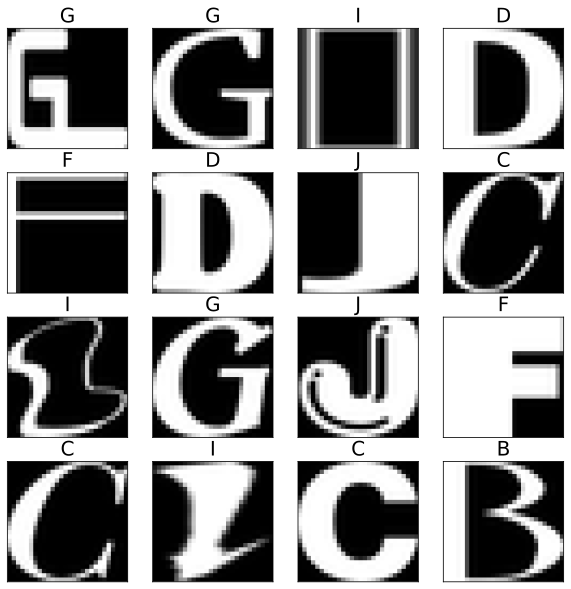

In [26]:
plot_letters(X_train, y_train, random_state=912)

## Function to measure the total execution time of all cells in a Jupyter Notebook
### My setup is Macbook Air M1

In [27]:
from IPython.core.magic import register_cell_magic
import time

total_time = 0

@register_cell_magic
def timeit(line, cell):
    global total_time
    start_time = time.time()
    exec(cell, globals())
    end_time = time.time()
    cell_execution_time = end_time - start_time
    total_time += cell_execution_time
    print(f"This cell took {cell_execution_time:.4f} seconds to run")

## Function for confusion matrix

In [28]:
%%timeit
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


This cell took 0.0003 seconds to run


## Make sure that you installed all required libraries (sklearn, tensorflow, matplotlib, seaborn)

## Logistic regression

Train Accuracy: 0.9153
Test Accuracy: 0.8970


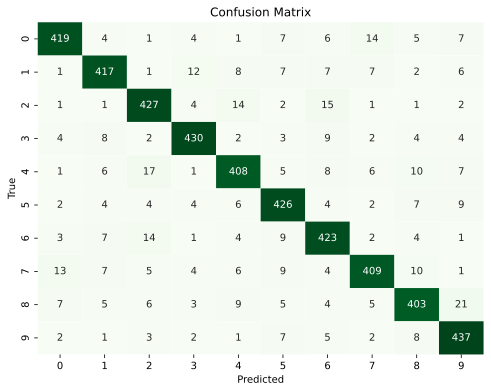

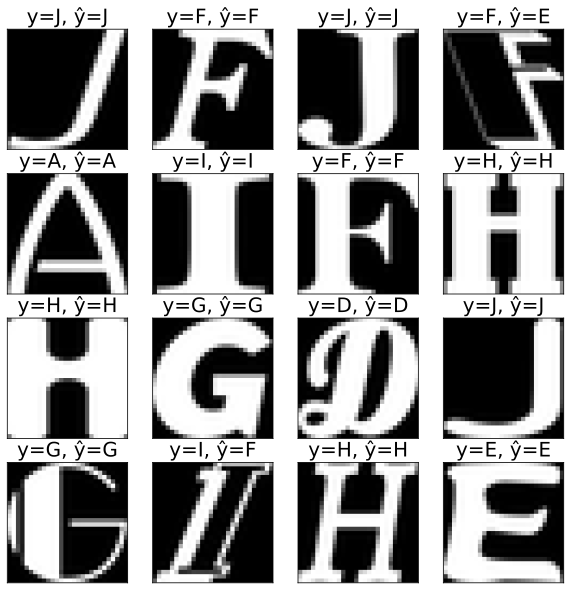

This cell took 2.2278 seconds to run


In [29]:
%%timeit
# Logistic regression
from sklearn.linear_model import LogisticRegression

# Reshape image data for Logistic Regression
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Initialize the Logistic Regression model
logistic_model = LogisticRegression(
    multi_class='multinomial',
    penalty='l1',
    solver='saga',
    tol=0.1,
    max_iter=1000,
    C=0.8
)

# Fit the model
logistic_model.fit(X_train_flat, y_train)

# Measure and print train and test accuracy
train_accuracy = logistic_model.score(X_train_flat, y_train)
test_accuracy = logistic_model.score(X_test_flat, y_test)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions on the test dataset
y_pred = logistic_model.predict(X_test_flat)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)


# Plot 16 random samples with true labels and predicted classes
plot_letters(X_test_flat, y_test, y_pred)


## kNN

Train Accuracy: 0.9997
Test Accuracy: 0.8872


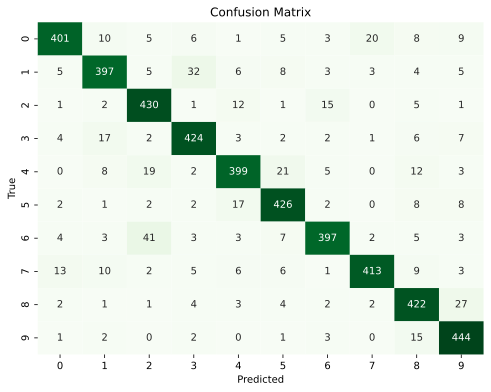

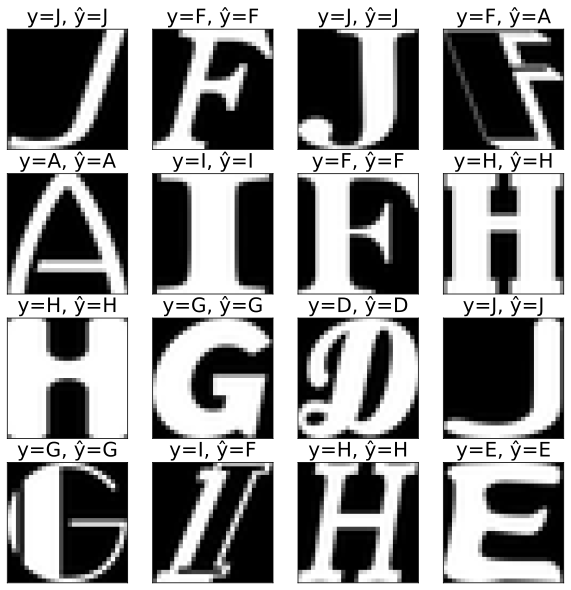

This cell took 3.9638 seconds to run


In [30]:
%%timeit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the kNN model with a specified number of neighbors
k = 6  # Number of neighbors
knn_model = KNeighborsClassifier(
    n_neighbors=k,
    weights='distance',
    n_jobs=-1
)

# Fit the kNN model
knn_model.fit(X_train, y_train)

# Measure and print train and test accuracy
train_accuracy = knn_model.score(X_train, y_train)
test_accuracy = knn_model.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions on the test dataset
y_pred = knn_model.predict(X_test)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

# Plot 16 random samples with true labels and predicted classes using the existing function
plot_letters(X_test, y_test, y_pred)


## Naive Bayes

Train Accuracy: 0.8060
Test Accuracy: 0.8092


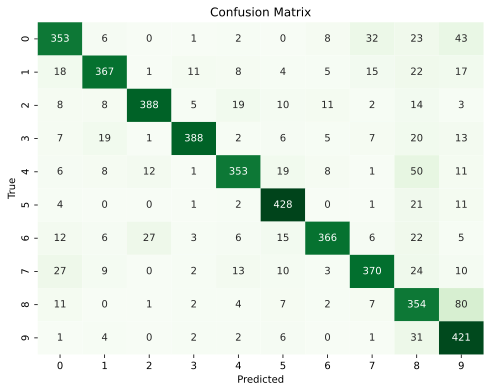

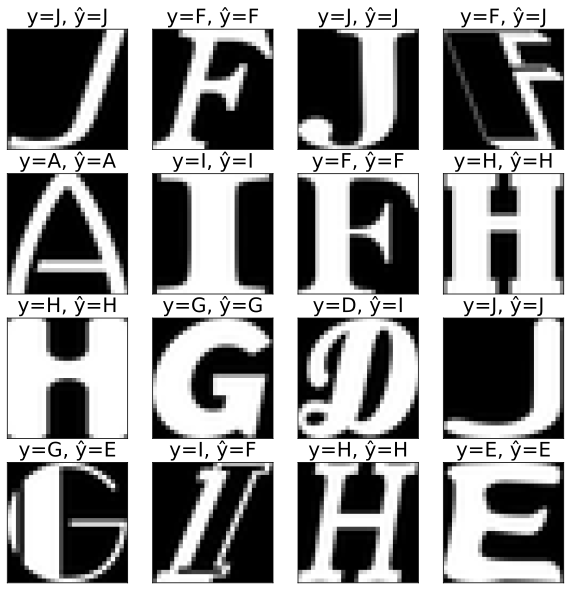

This cell took 1.1581 seconds to run


In [31]:
%%timeit
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import BaggingClassifier


# Initialize the Gaussian Naive Bayes model
nb_model = GaussianNB(var_smoothing=1e-15)
# Fit the Naive Bayes model
nb_model.fit(X_train, y_train)

# Measure and print train and test accuracy
train_accuracy = nb_model.score(X_train, y_train)
test_accuracy = nb_model.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions on the test dataset
y_pred = nb_model.predict(X_test)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

# Plot 16 random samples with true labels and predicted classes using the existing function
plot_letters(X_test, y_test, y_pred)


## Decision tree

Train Accuracy: 0.9190
Test Accuracy: 0.8274


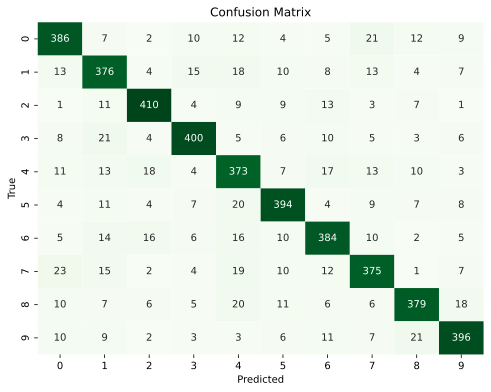

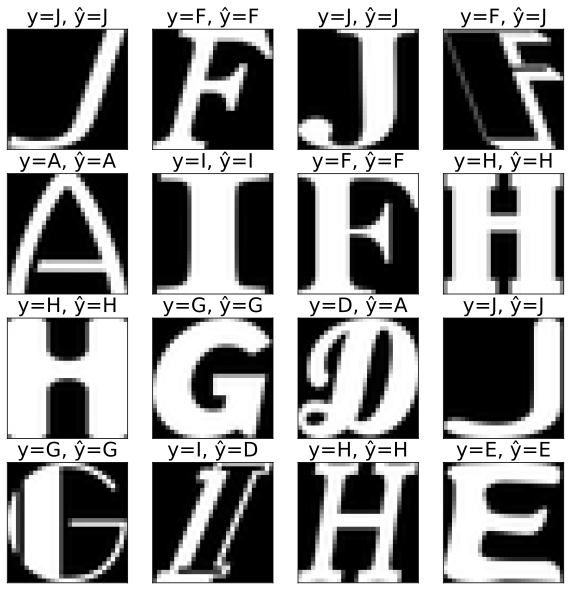

This cell took 3.6159 seconds to run


In [32]:
%%timeit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize the Decision Tree model
tree_model = DecisionTreeClassifier(
    min_samples_leaf=1,
    criterion='entropy',
    max_depth=9,
    splitter='best',
)

# Fit the Decision Tree model
tree_model.fit(X_train, y_train)

# Measure and print train and test accuracy
train_accuracy = tree_model.score(X_train, y_train)
test_accuracy = tree_model.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions on the test dataset
y_pred = tree_model.predict(X_test)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

# Plot 16 random samples with true labels and predicted classes using the existing function
plot_letters(X_test, y_test, y_pred)


## Random Forest

Train Accuracy: 0.9997
Test Accuracy: 0.9175


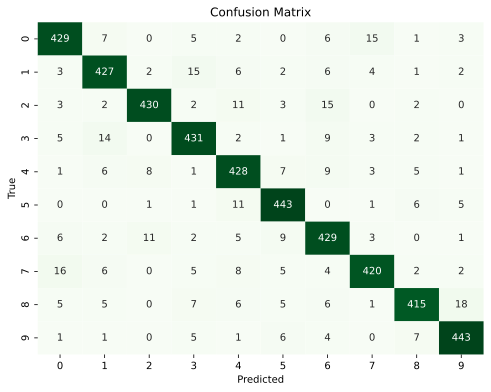

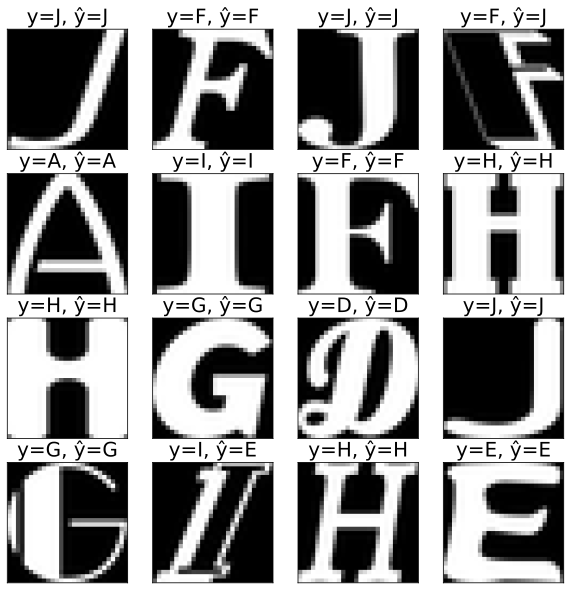

This cell took 4.6821 seconds to run


In [33]:
%%timeit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize the Random Forest model
forest_model = RandomForestClassifier(
    max_features='log2',
    n_estimators=500,
    max_depth=30,
    n_jobs=-1
)

# Fit the Random Forest model
forest_model.fit(X_train, y_train)

# Measure and print train and test accuracy
train_accuracy = forest_model.score(X_train, y_train)
test_accuracy = forest_model.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions on the test dataset
y_pred = forest_model.predict(X_test)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

# Plot 16 random samples with true labels and predicted classes using the existing function
plot_letters(X_test, y_test, y_pred)


## MLP

Train Accuracy: 0.9984
Test Accuracy: 0.9244


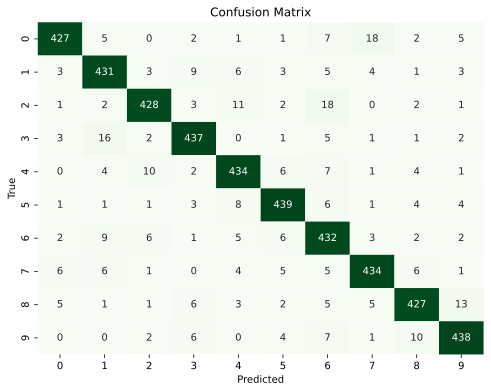

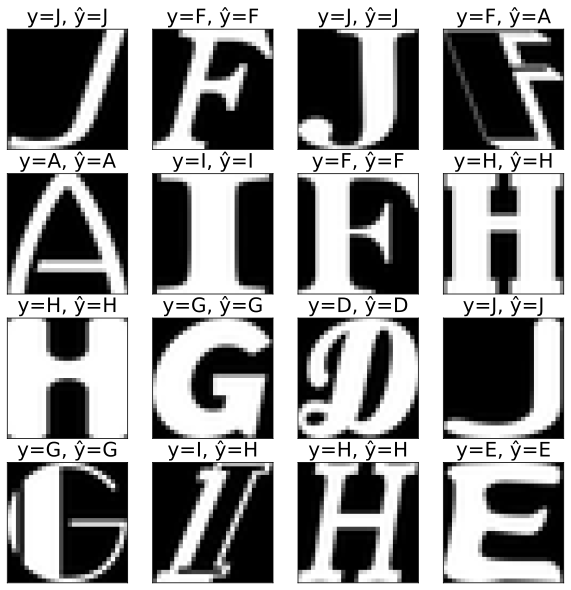

This cell took 41.1303 seconds to run


In [34]:
%%timeit
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize the MLP model
mlp_model = MLPClassifier(
    hidden_layer_sizes=(227, ),
    max_iter=2000,
    activation='relu',
    solver='adam',
    alpha=0.1,
)

# Fit the MLP model
mlp_model.fit(X_train, y_train)

# Measure and print train and test accuracy
train_accuracy = mlp_model.score(X_train, y_train)
test_accuracy = mlp_model.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions on the test dataset
y_pred = mlp_model.predict(X_test)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

# Plot 16 random samples with true labels and predicted classes using the existing function
plot_letters(X_test, y_test, y_pred)


## CNN (Make sure that you have installed tensorflow)

Epoch 1/15
110/110 [==============================] - 3s 22ms/step - loss: 0.9400 - accuracy: 0.6947 - val_loss: 0.4281 - val_accuracy: 0.8725
Epoch 2/15
110/110 [==============================] - 2s 21ms/step - loss: 0.4865 - accuracy: 0.8527 - val_loss: 0.3535 - val_accuracy: 0.8934
Epoch 3/15
110/110 [==============================] - 2s 22ms/step - loss: 0.3996 - accuracy: 0.8774 - val_loss: 0.3028 - val_accuracy: 0.9084
Epoch 4/15
110/110 [==============================] - 2s 22ms/step - loss: 0.3430 - accuracy: 0.8933 - val_loss: 0.2789 - val_accuracy: 0.9150
Epoch 5/15
110/110 [==============================] - 3s 23ms/step - loss: 0.3074 - accuracy: 0.9045 - val_loss: 0.2646 - val_accuracy: 0.9188
Epoch 6/15
110/110 [==============================] - 3s 24ms/step - loss: 0.2878 - accuracy: 0.9084 - val_loss: 0.2566 - val_accuracy: 0.9242
Epoch 7/15
110/110 [==============================] - 3s 23ms/step - loss: 0.2615 - accuracy: 0.9183 - val_loss: 0.2487 - val_accuracy: 0.9229

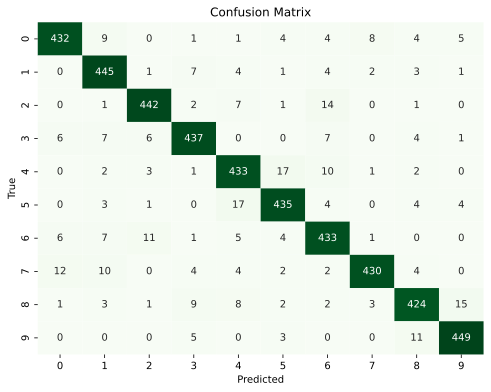

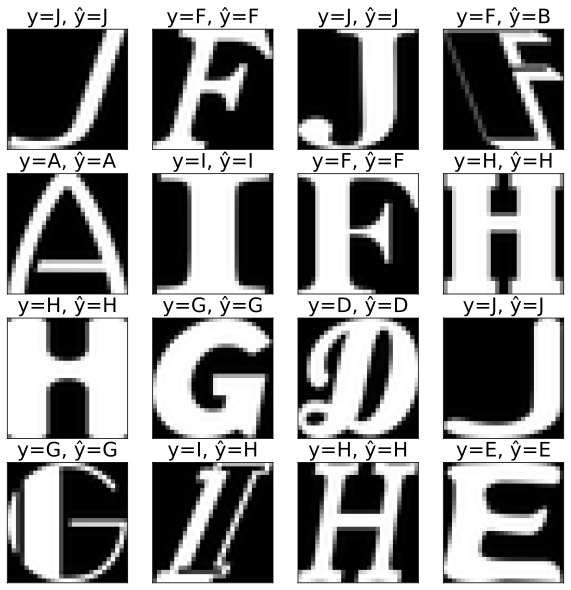

This cell took 41.7510 seconds to run


In [35]:
%%timeit
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Reshape the input data for CNN
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

# Define the CNN model
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the CNN model
history = cnn_model.fit(X_train_cnn, y_train, epochs=15, batch_size=128, validation_data=(X_test_cnn, y_test))

# Make predictions on the test dataset
y_pred_probs = cnn_model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_probs, axis=1)

train_loss, train_accuracy = cnn_model.evaluate(X_train_cnn, y_train, verbose=0)
print(f"Train Accuracy: {train_accuracy:.4f}")

# Measure and print test and train accuracy
test_loss, test_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

# Plot 16 random samples with true labels and predicted classes
plot_letters(X_test, y_test, y_pred)


## Plot results

In [36]:
%%timeit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Lists to store metrics
models_list = [logistic_model, knn_model, nb_model, tree_model, forest_model, mlp_model, cnn_model]
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

for model in models_list:
    if model == cnn_model:
        y_pred_probs = cnn_model.predict(X_test_cnn)
        y_pred = np.argmax(y_pred_probs, axis=1)
    else:
        y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)

    # Calculate precision
    precision = precision_score(y_test, y_pred, average='weighted')
    precision_scores.append(precision)

    # Calculate recall
    recall = recall_score(y_test, y_pred, average='weighted')
    recall_scores.append(recall)


147/147 [==============================] - 1s 3ms/step
This cell took 1.9932 seconds to run


## Print accuracy, recall, precision and F1 scores

In [37]:
%%timeit
print("Precision Scores:", precision_scores)
print("F1 Scores:", f1_scores)
print("Accuracy Scores:", accuracy_scores)
print("Recall Scores:", recall_scores)

Precision Scores: [0.8973699153067732, 0.8886509806001223, 0.8219821181728564, 0.8282237019134292, 0.9180588166844761, 0.9249272284331294, 0.9318191884631662]
F1 Scores: [0.8969753436802452, 0.8871058592349788, 0.8117593116170333, 0.8276576046075345, 0.9175749060795397, 0.9244891066991207, 0.9314679187773218]
Accuracy Scores: [0.8970305490279855, 0.8872035889767144, 0.8092287972655415, 0.8273873104037599, 0.9175389873958556, 0.924375133518479, 0.9314249092074343]
Recall Scores: [0.8970305490279855, 0.8872035889767144, 0.8092287972655415, 0.8273873104037599, 0.9175389873958556, 0.924375133518479, 0.9314249092074343]
This cell took 0.0002 seconds to run


## Accuracy Comparasion of Models

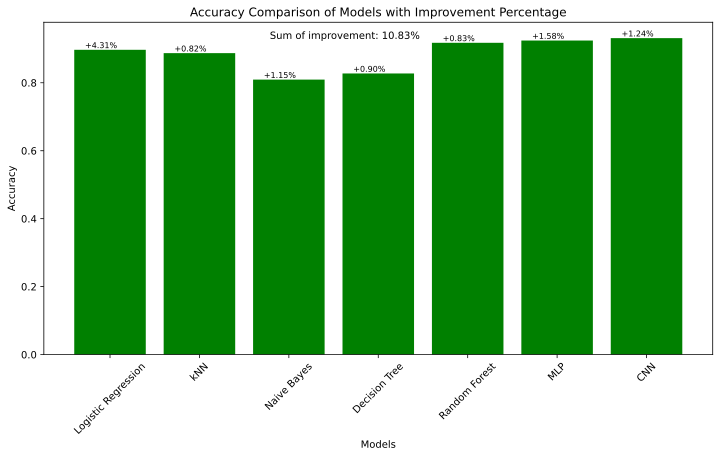

This cell took 0.0881 seconds to run


In [38]:
%%timeit
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'kNN', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'MLP', 'CNN']

baseline_accuracy = [0.86, 0.88, 0.80, 0.82, 0.91, 0.91, 0.92]

improvement_percentages = [round((accuracy - baseline) / baseline * 100, 2) for accuracy, baseline in zip(accuracy_scores, baseline_accuracy)]

colors = ['grey' if improvement <= 0 else 'green' for improvement in improvement_percentages]

plt.figure(figsize=(12, 6))
bars = plt.bar(models, accuracy_scores, color=colors)

# Adding improvement percentages on the bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.005, f"+{improvement_percentages[i]:.2f}%", ha='center', color='black', fontsize=8)

# Calculate and display the sum of improvement percentages
sum_improvement = sum(improvement_percentages)
plt.text(0.45, 0.95, f"Sum of improvement: {sum_improvement:.2f}%", transform=plt.gca().transAxes, fontsize=10, ha='center')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Models with Improvement Percentage')
plt.xticks(rotation=45)
plt.show()


## F1 Score Comparison of Models

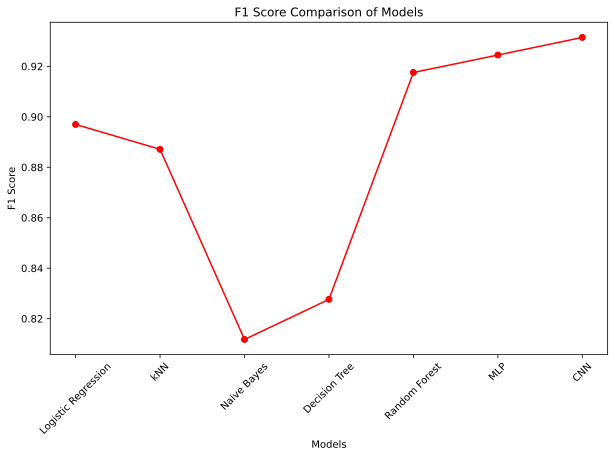

This cell took 0.0712 seconds to run


In [39]:
%%timeit
# Line plot comparing F1 scores of different models
plt.figure(figsize=(10, 6))
plt.plot(models, f1_scores, marker='o', linestyle='-', color='red')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison of Models')
plt.xticks(rotation=45)
plt.show()

## Precision Comparison of Models

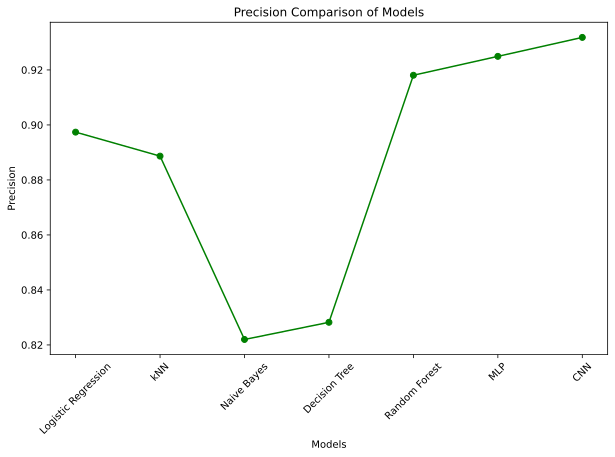

This cell took 0.0802 seconds to run


In [40]:
%%timeit
# Line plot comparing precision scores of different models
plt.figure(figsize=(10, 6))
plt.plot(models, precision_scores, marker='o', linestyle='-', color='green')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.title('Precision Comparison of Models')
plt.xticks(rotation=45)
plt.show()

## Recall Comparison of Models

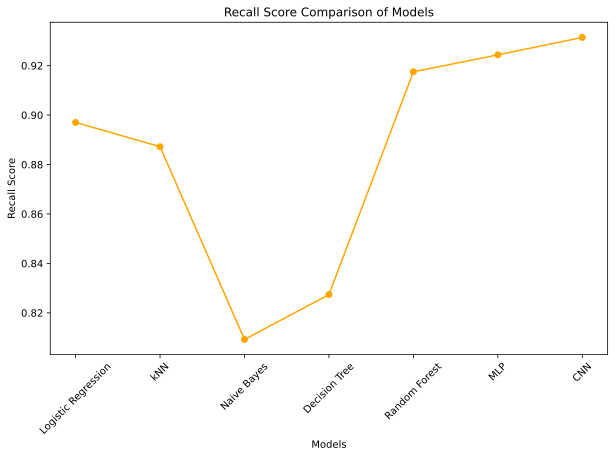

This cell took 0.0897 seconds to run


In [41]:
%%timeit
# Line plot comparing F1 scores of different models
plt.figure(figsize=(10, 6))
plt.plot(models, recall_scores, marker='o', linestyle='-', color='orange')
plt.xlabel('Models')
plt.ylabel('Recall Score')
plt.title('Recall Score Comparison of Models')
plt.xticks(rotation=45)
plt.show()

## Total execution time

In [45]:
%%timeit
print(f"Total execution time of cells with %%timeit: {total_time } seconds")

Total execution time of cells with %%timeit: 100.85216021537781 seconds
This cell took 0.0001 seconds to run
